In [2]:
import xarray as xr
from windrose import WindroseAxes
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import scipy
import cv2 as cv
from scipy.ndimage import rotate
from ocr.wind import apply_wind_directional_convolution, classify_wind_directions, apply_mode_calc, create_finescale_wind_direction, create_composite_bp_map
from ocr.utils import lon_to_180, interpolate_to_30, subset_region_xy, convert_coords
from ocr import catalog, load_structures_destroyed

In [3]:
# Load in 270m risk

In [4]:
riley = {}
riley['2011'] = catalog.get_dataset('2011-climate-run', version='v1').to_xarray(is_icechunk=True)
riley['2047'] = catalog.get_dataset('2047-climate-run', version='v1').to_xarray(is_icechunk=True)

In [5]:
structures = load_structures_destroyed(fire_name='Eaton', target_crs='EPSG:5070')

In [6]:
buffer = 20000
x_min, x_max = structures.geometry.x.min()-buffer, structures.geometry.x.max()+buffer
y_min, y_max = structures.geometry.y.min()-buffer, structures.geometry.y.max()+buffer

In [7]:
subset = subset_region_xy(riley['2011'], [x_min, x_max], [y_min, y_max])

In [8]:
[(lon_min, lat_max), (lon_max, lat_min)] = convert_coords([(x_min, y_max), (x_max, y_min)], from_crs='EPSG:5070', to_crs='EPSG:4326')

In [9]:
# expand the lats a smidge to make sure lat and lon dim lengths are both >1. it fails if dim length is 1. fixing this corner-case is low-priority.
lat_max += 0.2
lat_min -= 0.2
lon_max += 0.15
lon_min -= 0.15

In [10]:
lat_min, lat_max

(33.83876542382757, 34.547165362701236)

In [11]:
lon_min, lon_max

(-118.58257440430289, -117.60416825093)

In [12]:
# load in the 30m product as a template
# TODO: swap in the CONUS newer version from raphael
rps_30 = rioxarray.open_rasterio('s3://carbonplan-risks/wildfirecommunities/RPS_CA.tif')

In [13]:
rps_30 = subset_region_xy(rps_30, [x_min, x_max], [y_min, y_max]).sel(band=1)

In [14]:
subset_30 = interpolate_to_30(subset, rps_30)

In [15]:
subset_30 = subset_30.rio.write_crs('EPSG:5070')

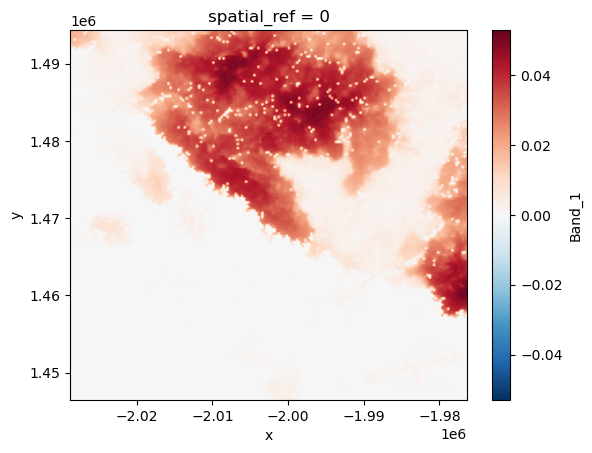

In [16]:
subset_30.BP.plot()

In [17]:
# reprojecting introduces a lot of nans which presents two TODOs
# (1) the convolution doesn't handle nans (at least presently). fill those with -9999s for now. 
# TODO: this is an imperfect solution we want to fix to limit errors down the road. the 
# (2) the reprojection decreases the useable data, meaning that we need to increase the buffer 
# that we clip around the edges of the data tile 
subset_30 = subset_30.rio.reproject('EPSG:4326').fillna(-9999)

In [18]:
# Create a BP map smeared according to each of the 8 cardinal and intercardinal directions

In [19]:
blurred_bp = apply_wind_directional_convolution(subset_30['BP'], iterations=3)

In [20]:
# Load in the dataset of wind for fire weather days

In [21]:
important_days = catalog.get_dataset('era5-fire-weather-days', version='v2').to_xarray(
    is_icechunk=False, xarray_open_kwargs={'engine': 'zarr'}
)

Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7f56bd1a9e50>
Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0x7f56bd263d10>, 2013.754472821)])']
connector: <aiohttp.connector.TCPConnector object at 0x7f56bd1a9a90>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7f56bdc37890>
Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0x7f56bd263a10>, 2013.770445197)])']
connector: <aiohttp.connector.TCPConnector object at 0x7f56bdc374d0>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7f56bde5e990>
Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0x7f56bd263f50>, 2013.774592799)])']
connector: <aiohttp.connector.TCPConnector object at 0x7f56bd1fc640>


In [22]:
important_days = lon_to_180(important_days)

In [23]:
subset_wind = important_days.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
wind_directions = subset_wind['sfcWindfromdir']

In [24]:
# we only have to do the wind direction classification once - want to get the distribution of each direction. prep this and store it like `fire_weather_days_v2.zarr`

In [25]:
direction_indices = classify_wind_directions(wind_directions).chunk(dict(time=-1))

/opt/coiled/env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


In [26]:
direction_modes = apply_mode_calc(direction_indices).compute()

In [27]:
direction_modes_reprojected = create_finescale_wind_direction(blurred_bp, direction_modes)

In [28]:
wind_informed_bp = create_composite_bp_map(blurred_bp, direction_modes_reprojected)

In [29]:
# load in the crps because we'll use it as the template to register the BP to

In [30]:
crps = rioxarray.open_rasterio('s3://carbonplan-risks/wildfirecommunities/CRPS_CA.tif')

In [31]:
subset_crps = crps.sel(x=slice(x_min, x_max), y=slice(y_max, y_min))

In [32]:
wind_informed_bp = wind_informed_bp.rio.reproject_match(subset_crps)

In [33]:
# TODO: decide how big of a buffer to trim it down. the size of the kernel plus a little to play it safe?

In [34]:
wind_informed_bp = wind_informed_bp.sel(x=slice(x_min, x_max), y=slice(y_max, y_min))

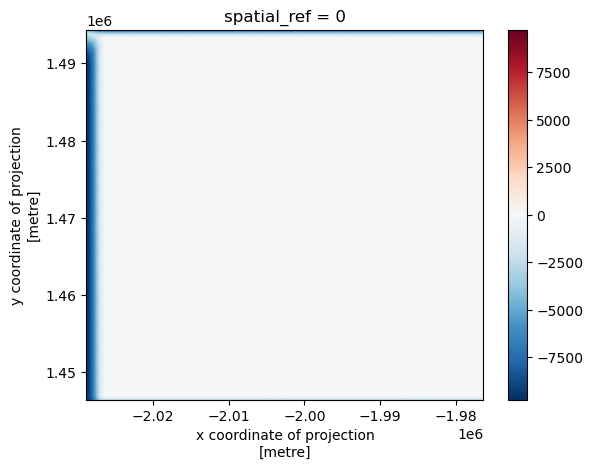

In [35]:
wind_informed_bp.plot()

In [38]:
wind_informed_bp.to_dataset(name='BP').to_zarr('s3://carbonplan-risks/ocr/v0/intermediates/bp.zarr', mode='w')

/opt/coiled/env/lib/python3.13/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


<Axes: title={'center': 'spatial_ref = 0, band = 1'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

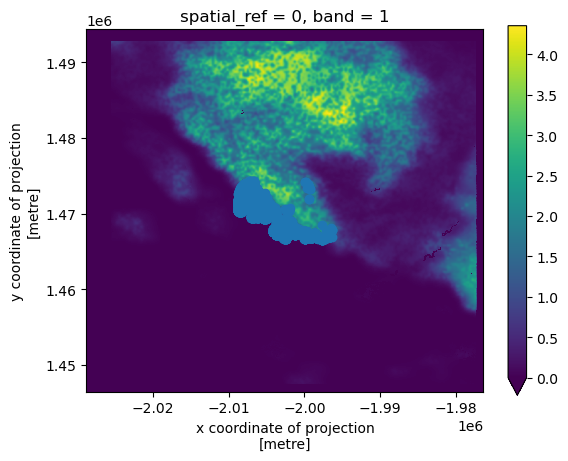

In [34]:
fig, ax = plt.subplots()
(wind_informed_bp * subset_crps).plot(ax=ax, vmin=0)
structures.plot(ax=ax)

In [35]:
bp_orig = rioxarray.open_rasterio('s3://carbonplan-risks/wildfirecommunities/BP_CA.tif')

<Axes: title={'center': 'spatial_ref = 0, band = 1'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

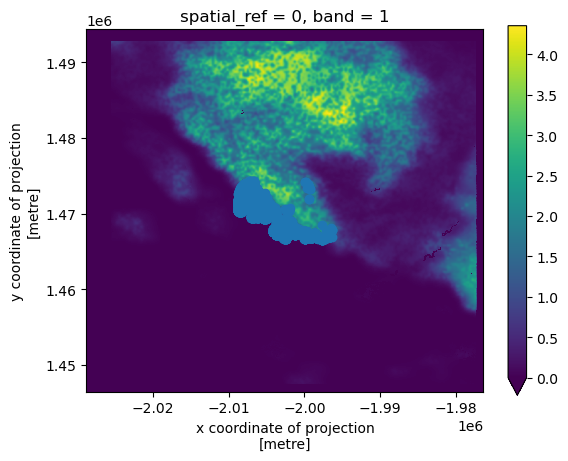

In [37]:
fig, ax = plt.subplots()
(wind_informed_bp['BP'] * subset_crps).plot(vmin=0)
structures.plot(ax=ax)

In [39]:
risk = (wind_informed_bp * subset_crps).to_dataset(name='risk')

In [40]:
risk.where(risk>0, 0).to_zarr('s3://carbonplan-risks/ocr/v0/intermediates/risk.zarr', mode='w')

/opt/coiled/env/lib/python3.13/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
